In [1]:
import os
import shutil
from cv2 import *
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.applications.resnet_v2 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from numpy import expand_dims
import seaborn as sns
from PIL import Image
from tensorflow.keras import models

In [2]:
IMG_SIZE = 150

TRAINING_DIR = "Face Mask Dataset/Train"
training_datagen = ImageDataGenerator(rescale=1/255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')
train_generator = training_datagen.flow_from_directory(TRAINING_DIR,
                                                       target_size=(IMG_SIZE,IMG_SIZE) ,class_mode='binary',
                                                       batch_size=64,shuffle=True )


TEST_DIR = "Face Mask Dataset/Test"
test_datagen = ImageDataGenerator(rescale = 1/255)
test_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=(IMG_SIZE,IMG_SIZE), class_mode='binary',
                                                  batch_size=64,
                                                  shuffle=False)

VAL_DIR = "Face Mask Dataset/Validation"
val_datagen = ImageDataGenerator(rescale = 1/255)
val_generator = val_datagen.flow_from_directory(VAL_DIR,target_size=(IMG_SIZE,IMG_SIZE), class_mode='binary',
                                                  batch_size=64,
                                                  shuffle=False)

Found 1315 images belonging to 2 classes.
Found 194 images belonging to 2 classes.
Found 142 images belonging to 2 classes.


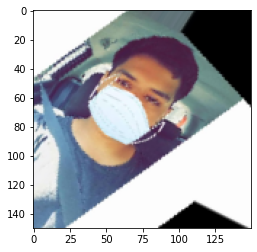

In [3]:
x,y = train_generator.next()
for i in range(0,1):
    image = x[i]
    plt.imshow(image)
    plt.show()

In [8]:
feature_extractor = tf.keras.applications.ResNet50V2(include_top=False,weights='imagenet',input_shape=(IMG_SIZE,IMG_SIZE,3))
feature_extractor.trainable = False

In [18]:
model=tf.keras.Sequential([
      feature_extractor,
      tf.keras.layers.Flatten(), 
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Activation('sigmoid')               
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 36,672,513
Trainable params: 13,107,713
Non-trainable params: 23,564,800
_________________________________

In [19]:
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')]

# lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=2, mode='min')

model.compile(optimizer=tf.optimizers.Adam(),loss='binary_crossentropy',metrics=METRICS )

history = model.fit(train_generator , epochs=10 , validation_data=val_generator)

Epoch 1/10
21/21 [==============================] - 8s 394ms/step - loss: 0.8730 - accuracy: 0.9468 - precision: 0.9536 - recall: 0.9391 - val_loss: 1.4413e-13 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/10
21/21 [==============================] - 7s 347ms/step - loss: 0.6073 - accuracy: 0.9795 - precision: 0.9817 - recall: 0.9772 - val_loss: 9.9006e-08 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/10
21/21 [==============================] - 8s 357ms/step - loss: 0.4314 - accuracy: 0.9802 - precision: 0.9788 - recall: 0.9817 - val_loss: 2.9430e-14 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/10
21/21 [==============================] - 7s 350ms/step - loss: 0.3390 - accuracy: 0.9825 - precision: 0.9832 - recall: 0.9817 - val_loss: 4.8393e-12 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/10
21/21 [==============================] - 7s 351ms/step - loss: 0.1984 - accur

In [21]:
model.evaluate(test_generator, batch_size=32)

4/4 [==============================] - 0s 52ms/step - loss: 0.0953 - accuracy: 0.9897 - precision: 0.9897 - recall: 0.9897


[0.09526395052671432,
 0.9896907210350037,
 0.9896907210350037,
 0.9896907210350037]

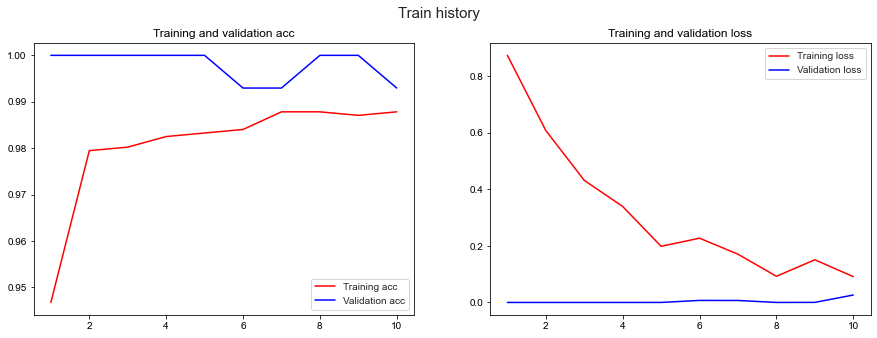

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']                                              
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, "b", label = "Training acc", color='red')
ax1.plot(epochs, val_acc, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss, "b", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'blue')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

In [12]:
model.save("Model/final_model_new_dataset_150.h5")

In [23]:
model = models.load_model("Model/final_model_new_dataset_150.h5")

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 36,672,513
Trainable params: 13,107,713
Non-trainable params: 23,564,800
_________________________________________________________________


In [25]:
def preprocessing(img):
    # img = cvtColor(img, COLOR_BGR2RGB)
    img = cv2.resize(img, (150,150))
    img = img/255.0
    img=np.reshape(img,(1,150,150,3))
    return img

In [26]:
cap = cv2.VideoCapture(0)
while True:
    success, img = cap.read()

    pred = model.predict(preprocessing(img))
    final_pred = np.round(pred)[0]

    if final_pred[0] == 1:
        cv2.putText(img, "Without Mask", (200,100), cv2.FONT_HERSHEY_COMPLEX, 0.7, (0, 0, 255), 2)
    else:
        cv2.putText(img, "With Mask", (200, 100), cv2.FONT_HERSHEY_COMPLEX, 0.7, (0, 255, 0), 2)

    cv2.imshow("Mask Detection", img)
    
    if cv2.waitKey(1) & 0xff == ord('q'):
        break

cap.release() 
cv2.destroyAllWindows() 